In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import GMMflow, GMMflow_SDP
import torchsde
import torch
from torch.distributions import Categorical, MultivariateNormal, MixtureSameFamily
from third_party.plot_confidence_region import *
import matplotlib.pyplot as plt

# 2D example

In [40]:
n0 = 1
r0 = 0

n1 = 8
r1 = 10

Mu0 = torch.tensor([[np.cos(th)*r0, np.sin(th)*r0] for th in np.linspace(0, 2*(1 - 1/n0)*np.pi, n0)], dtype=torch.float32)
Mu1 = torch.tensor([[np.cos(th)*r1, np.sin(th)*r1] for th in np.linspace(0, 2*(1 - 1/n1)*np.pi, n1)], dtype=torch.float32)

# Sigma1 = torch.concat([torch.eye(2).unsqueeze(0)*(0.2 + 0.5*i) for i in range(Mu1.shape[0])])
Sigma0 = torch.concat([torch.eye(2).unsqueeze(0)*0.4 for _ in range(Mu0.shape[0])])
Sigma1 = torch.concat([torch.eye(2).unsqueeze(0)*(0.2) for i in range(Mu1.shape[0])])


mix0 = Categorical(torch.ones(Mu0.shape[0],))
rho0 = MixtureSameFamily(mix0, MultivariateNormal(loc=Mu0, covariance_matrix=Sigma0))
mix1 = Categorical(torch.ones(Mu1.shape[0],))
rho1 = MixtureSameFamily(mix1, MultivariateNormal(loc=Mu1, covariance_matrix=Sigma1))

A = np.zeros((2,2))
B = np.eye(2)
D = np.eye(2)

In [41]:
S0 = torch.stack([s.diag() for s in Sigma0], dim=0)
S1 = torch.stack([s.diag() for s in Sigma1], dim=0)

(-20.0, 20.0)

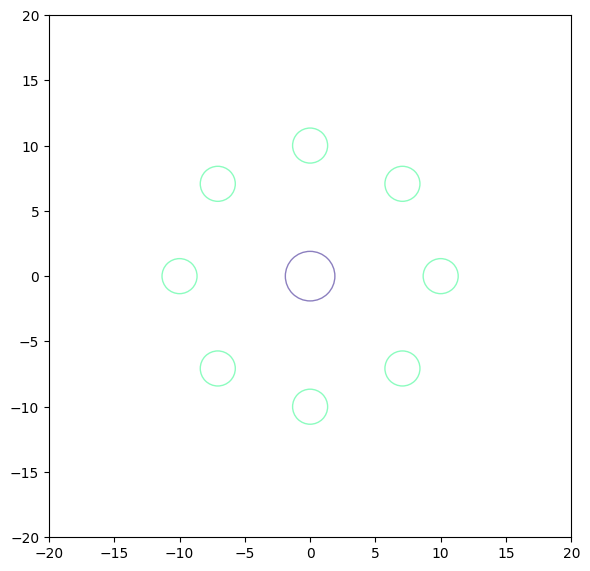

In [42]:
fig, ax = plt.subplots(sharex=True, sharey=True, tight_layout=True)
fig.set_size_inches(6, 6)

blue = (0.1, 0/50, 0.5, 0.5)
grn  = (0.1, 49/50, 0.5, 0.5)

for s, mu in zip(Sigma0, Mu0):
    confidence_ellipse(ax, cov=s[0:2, 0:2], mean=mu[0:2], edgecolor=blue, n_std=3.0)
    ax.set_aspect('equal')

for s, mu in zip(Sigma1, Mu1):
    confidence_ellipse(ax, cov=s[0:2, 0:2], mean=mu[0:2], edgecolor=grn, n_std=3.0)
    ax.set_aspect('equal')
    
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])

0.0  J_OT:  tensor(101.7657) J_true:    tensor(89.2822)
0.1  J_OT:  tensor(100.7380) J_true:    tensor(89.1847)
1.0  J_OT:  tensor(103.4835) J_true:    tensor(88.3047)
10.0  J_OT:  tensor(125.5615) J_true:    tensor(98.8076)


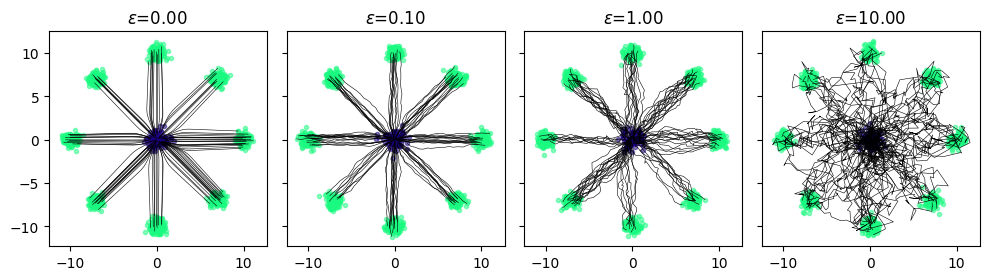

In [43]:
noise_levels = [0., 0.1, 1., 10.]
fig, ax = plt.subplots(1,4, sharey=True, sharex=True, tight_layout=True)
fig.set_size_inches(10,4)
torch.manual_seed(1024)

for i, epsilon in enumerate(noise_levels):

    sde = GMMflow(Mu0=Mu0, Mu1=Mu1, S0=S0, S1=S1, W0=None, W1=None, epsilon=np.sqrt(epsilon), device='cpu')

    y0 = rho0.sample([1000])
    t = torch.linspace(0, 1., 20)
    y = torchsde.sdeint(sde, y0, t, method='euler')
    for k in range(100):
        ax[i].plot(y[:, k, 0], y[:, k, 1], 'k', linewidth=0.4)

    # X0 = sde.sample_rho(t=0., B=1000)
    X0 = y[0]
    ax[i].plot(X0[0:100, 0], X0[0:100, 1], '.', color=blue, zorder=-1)

    # X1 = sde.sample_rho(1., 1000)
    X1 = y[-1]
    ax[i].plot(X1[:, 0], X1[:, 1], '.', color=grn, zorder=-1)
    ax[i].set_aspect('equal')
    ax[i].set_title(r'$\epsilon$={:.2f}'.format(epsilon), )
    print(epsilon, " J_OT: ", sde.calc_JOT(), "J_true:   ", sde.calc_Jtrue())

# fig.savefig('../figures/GMMS_flat_2.png', bbox_inches='tight')

# 4D example

In [36]:
n0 = 1
r0 = 0

n1 = 8
r1 = 10

Mu0 = torch.tensor([[np.cos(th) * r0, np.sin(th) * r0, 0, 0] for th in np.linspace(0, 2 * (1 - 1 / n0) * np.pi, n0)], dtype=torch.float32)
Mu1 = torch.tensor([[np.cos(th) * r1, np.sin(th) * r1, 0, 0] for th in np.linspace(0, 2 * (1 - 1 / n1) * np.pi, n1)], dtype=torch.float32)

Sigma0 = torch.concat([torch.eye(4).unsqueeze(0) * 0.4 for _ in range(Mu0.shape[0])])
Sigma1 = torch.concat([torch.eye(4).unsqueeze(0) * 0.2 for _ in range(Mu1.shape[0])])

mix0 = Categorical(torch.ones(Mu0.shape[0], ))
rho0 = MixtureSameFamily(mix0, MultivariateNormal(loc=Mu0, covariance_matrix=Sigma0))
mix1 = Categorical(torch.ones(Mu1.shape[0], ))
rho1 = MixtureSameFamily(mix1, MultivariateNormal(loc=Mu1, covariance_matrix=Sigma1))
#define system dynamics: 

A = np.array([[0. ,  -2.,  1., 0.], 
              [2.,   0.,  0., 1.], 
              [0.,  -1,   0., 0.],
              [1, 0.0,   0., 0.]])

B = np.zeros((4, 2))
B[2:4, :] = np.eye(2)
D = np.eye(4)

0.0 J_OT:  tensor(1202.2057) J_exp:    tensor(1132.1705)
0.1 J_OT:  tensor(1204.1973) J_exp:    tensor(1133.7262)
1.0 J_OT:  tensor(1360.5804) J_exp:    tensor(1288.3521)
5.0 J_OT:  tensor(23274.1953) J_exp:    tensor(23158.7891)


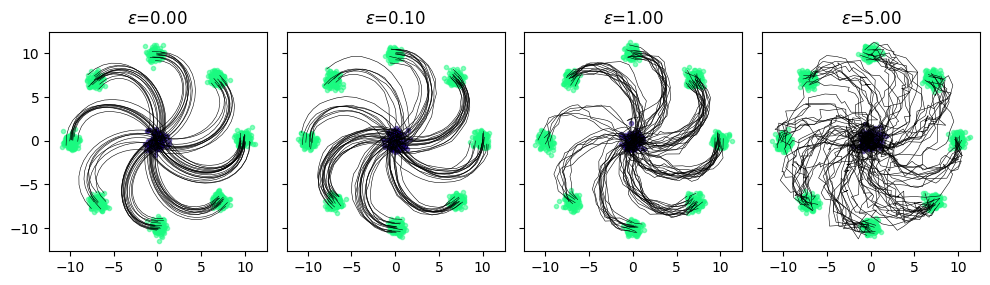

In [38]:
noise_levels = [0., 0.1, 1., 5.]
fig, ax = plt.subplots(1,4, sharey=True, sharex=True, tight_layout=True)
fig.set_size_inches(h=4, w=10)

for i, epsilon in enumerate(noise_levels):
    
    sde = GMMflow_SDP(Mu0=Mu0, Mu1=Mu1, Sigma0=Sigma0, Sigma1=Sigma1, W0=None, W1=None, A=A, B=B, D=np.sqrt(epsilon)*D, N = 201)
    
    y0 = rho0.sample([1000])
    t = torch.linspace(0, 1., 20)
    y = torchsde.sdeint(sde, y0, t, method='euler')
    for k in range(100):
        ax.flat[i].plot(y[:, k, 0], y[:, k, 1], 'k', linewidth=0.4)
    
    # X0 = sde.sample_rho(0., 1000)
    X0 = y[0]
    ax.flat[i].plot(X0[0:100, 0], X0[0:100, 1], '.', color=blue, zorder=-1)
    
    # X1 = sde.sample_rho(1., 1000)
    X1 = y[-1]
    ax.flat[i].plot(X1[:, 0], X1[:, 1], '.', color=grn, zorder=-1)
    ax.flat[i].set_aspect('equal')
    ax.flat[i].set_title(r'$\epsilon$={:.2f}'.format(epsilon), )
    print(epsilon, "J_OT: ", sde.calc_JOT(), "J_true:   ", sde.calc_Jtrue())

# fig.savefig('../figures/4D_GMM.png', bbox_inches='tight')